In [ ]:
!pip -qq install -U langchain langchain-community langgraph pydantic google-ai-generativelanguage==0.6.15 langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.4/462.4 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 15.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [ ]:
import os
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage, HumanMessage

from google.colab import userdata

from getpass import getpass
import os

# Enter the key securely (won't be visible when typed)
os.environ['API_KEY'] = getpass('Enter your API key: ')

# Use the key
GOOGLE_API_KEY = os.environ['API_KEY']


Enter your API key: ··········


Prompt Chaining

In [ ]:
# Define LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are an expert technical writer. Always give clear,
     concise, and straight-to-the-point answers."""
)

# Define the graph state
class State(dict):
    text: str
    topics: str
    title: str

# Define nodes (steps)
def extract_topics(state: State) -> State:
    prompt = f"Extract 1-3 key topics from the following text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["topics"] = resp.content.strip()
    return state

def generate_title(state: State) -> State:
    prompt = f"Generate two catchy blog titles for each one these topics:\n\n{state['topics']}"
    resp = llm.invoke(prompt)
    state["title"] = resp.content.strip()
    return state

# Build the graph
workflow = StateGraph(State)
workflow.add_node("extract_topics", extract_topics)
workflow.add_node("generate_title", generate_title)

# Flow: extract_topics → generate_title → END
workflow.set_entry_point("extract_topics")
workflow.add_edge("extract_topics", "generate_title")
workflow.add_edge("generate_title", END)

# Compile runnable graph
graph = workflow.compile()

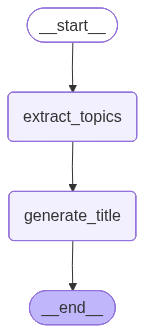

In [ ]:
graph

In [ ]:
# Run the graph
input_text = (
    "LlamaIndex agents are AI-powered reasoning and decision engines designed to automate complex tasks, especially those involving your private or domain-specific data. "
    "LlamaIndex is highly regarded for its data-centric approach and strong features for Retrieval-Augmented Generation (RAG) when compared to other frameworks like LangChain or CrewAI. "
)

result = graph.invoke({"text": input_text})
print("Topics:", result["topics"])
print("\n"+"="*50+"\n")
print("Suggested Blog Title:", result["title"])

Topics: Here are 2 key topics extracted from the text:

1.  **LlamaIndex Agents:** The text introduces LlamaIndex agents as a core concept.
2.  **Data-Centric RAG:** The text highlights LlamaIndex's strength in data-focused Retrieval-Augmented Generation (RAG) compared to other frameworks.


Suggested Blog Title: Okay, here are two catchy blog titles for each of the topics you provided:

**1. LlamaIndex Agents:**

*   **Title 1:** Unleash the Power of LlamaIndex Agents: Your Guide to AI-Powered Data Wrangling
*   **Title 2:** Beyond Chatbots: How LlamaIndex Agents are Redefining AI Automation

**2. Data-Centric RAG:**

*   **Title 1:** Stop Guessing, Start Knowing: Data-Centric RAG with LlamaIndex
*   **Title 2:** LlamaIndex RAG: Where Data Reigns Supreme (and Why You Should Care)


Routing

In [ ]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are a helpful assistant that can classify text
    sentiment and respond accordingly."""
)

# State definition
class State(dict):
    text: str
    sentiment: str
    response: str

# Nodes
def calssification(state: State) -> str:
    """Classify sentiment."""
    prompt = f"Is the following text positive or negative? Answer with one word only: Positive or Negative.\n\n{state['text']}"
    resp = llm.invoke(prompt)
    sentiment = resp.content.strip().lower()
    state["sentiment"] = sentiment
    return state

def positive_node(state: State) -> State:
    prompt = f"Generate an encouraging reply to this positive text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def negative_node(state: State) -> State:
    prompt = f"Generate a supportive reply to this negative text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def router_func(state: State) -> Literal["positive", "negative"]:
    """Return next node name."""
    return "positive" if "positive" in state["sentiment"] else "negative"

# Build the graph
workflow = StateGraph(State)

workflow.add_node("calssification", calssification)
workflow.add_node("positive", positive_node)
workflow.add_node("negative", negative_node)

# classify node decides the next step
workflow.set_entry_point("calssification")
workflow.add_conditional_edges("calssification", router_func, {
    "positive": "positive",
    "negative": "negative",
})

# Both branches lead to END
workflow.add_edge("positive", END)
workflow.add_edge("negative", END)

graph = workflow.compile()

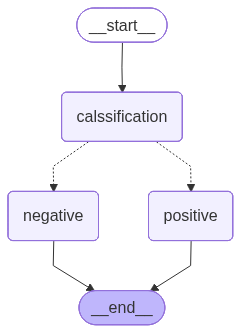

In [ ]:
graph

In [ ]:
# Run example
input_text = "I am very excited to learn and explore the world of AI"
result = graph.invoke({"text": input_text})
print("Sentiment:", result["sentiment"])
print("Response:", result["response"])


Sentiment: positive
Response: That's fantastic! Your enthusiasm is contagious. The world of AI is incredibly exciting, and I'm so glad you're diving in. Get ready for a journey of endless learning and discovery - you're going to love it! Let me know if you ever want to chat about what you're learning!


Parallelization

In [ ]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
)

# State definition
class State(TypedDict):
    text: str
    # Reducer makes these append-only so multiple nodes can update in parallel
    outputs: Annotated[list, operator.add]

# Nodes
def summarize(state: State):
    prompt = f"Summarize in one sentence:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Summary: {resp.content.strip()}"]}

def critique(state: State):
    prompt = f"Critique briefly:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Critique: {resp.content.strip()}"]}

def combine(state: State):
    prompt = f"Combine the following Critique and Summarization in one \
    paragraph:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Combined:\n{resp.content.strip()}"]}

# Build the graph
builder = StateGraph(State)
builder.add_node("summarize", summarize)
builder.add_node("critique", critique)
builder.add_node("combine", combine)

# Parallel edges: summarize and critique run side by side
builder.add_edge(START, "summarize")
builder.add_edge(START, "critique")

# Both join into combine
builder.add_edge("summarize", "combine")
builder.add_edge("critique", "combine")

builder.add_edge("combine", END)

graph = builder.compile()

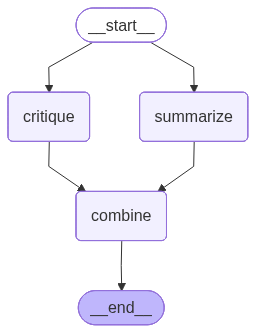

In [ ]:
graph

In [ ]:
# --- Run example ---
input_text = "Agentic AI architecture provides the structural framework for creating autonomous, goal-oriented AI systems that can reason, plan, and execute multi-step tasks with minimal human intervention."
result = graph.invoke({"text": input_text, "outputs": []})

print("\nFinal outputs:")
for out in result["outputs"]:
    print(out)
    print("="*100 + "\n")


Final outputs:
Critique: The statement is clear, concise, and accurately captures the essence of agentic AI. It effectively describes **what agentic AI systems do** and **what the architecture enables**.

**Critique:**

While excellent for describing the *purpose* and *outcomes* of agentic AI, it leans more towards defining the *capabilities of the resulting systems* rather than explicitly detailing what constitutes the "architectural framework" itself. It doesn't mention typical architectural components (e.g., perception, world model, planning module, memory, action interfaces) which would usually be part of an "architecture" definition.

**In short:** Great description of the *what* and *why*, but less about the *how* from an architectural component perspective.

Summary: Agentic AI architecture provides the structural framework for creating autonomous, goal-oriented AI systems that can reason, plan, and execute multi-step tasks with minimal human intervention.

Combined:
Agentic AI

Reflection

In [ ]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
)

# State
class State(TypedDict):
    task: str
    draft: str
    feedback: str
    final: str

# Nodes
def generator(state: State):
    """Generate an initial or refined draft."""
    prompt = f"""
You are an assistant helping to complete the following task:

Task:
{state['task']}

Current Draft:
{state.get('draft', 'None')}

Feedback:
{state.get('feedback', 'None')}

Instructions:
- If there is no draft and no feedback, generate a clear and complete response to the task.
- If there is a draft but no feedback, improve the draft as needed for clarity and quality.
- If there is both a draft and feedback, revise the draft by incorporating the feedback directly.
- Always produce a single, improved draft as your output.
"""
    resp = llm.invoke(prompt)
    return {"draft": resp.content.strip()}

def evaluator(state: State):
    """Evaluate the draft and give feedback or approval."""
    prompt = f"""Evaluate the following draft, based on the given task.
If it meets the requirements, reply exactly 'APPROVED'.
Otherwise, provide constructive feedback for improvement.
Task:
{state['task']}
Draft:
{state['draft']}"""
    resp = llm.invoke(prompt)
    print(f"""
================= DRAFT =================
{state['draft']}

================ FEEDBACK ===============
{resp.content.strip()}
========================================
""")
    return {"feedback": resp.content.strip()}

def decide(state: State) -> str:
    """Decide next step: either approve and finish, or refine again."""
    if "APPROVED" in state["feedback"].upper():
        return "approved"
    return "refine"

def finalize(state: State):
    """Save the final approved draft."""
    return {"final": state["draft"]}

# Build the graph
builder = StateGraph(State)

builder.add_node("generator", generator)
builder.add_node("evaluator", evaluator)
builder.add_node("finalize", finalize)

builder.add_edge(START, "generator")
builder.add_edge("generator", "evaluator")
builder.add_edge("evaluator", "finalize")

# Conditional edges from decide
builder.add_conditional_edges(
    "evaluator",
    decide,
    {
        "approved": "finalize",   # stop loop
        "refine": "generator",    # go back for improvement
    },
)

builder.add_edge("finalize", END)

graph = builder.compile()

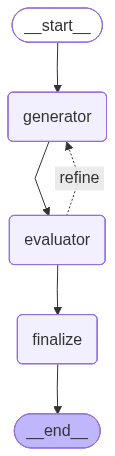

In [ ]:
graph

In [ ]:
# Run example
input_task = "You have six horses and want to race them to see which is f astest. What is the best way to do this?"
result = graph.invoke({"task": input_task})

print("\nFinal Answer:\n", result["final"])


================= DRAFT =================
The best way to determine which of six horses is fastest is to race them all simultaneously under identical conditions.

Here's how:

1.  **Preparation:** Ensure all six horses are properly prepared, with appropriate jockeys and in similar physical condition.
2.  **Track Setup:** Use a standard race track that can accommodate all six horses. Ensure the track conditions (surface, distance, starting gate) are fair and uniform for all participants.
3.  **The Race:** Start all six horses at the same time over a predetermined race distance.
4.  **Observation:** The horse that crosses the finish line first is the fastest.

This method directly compares all horses against each other in a single event, providing the most direct, fair, and efficient assessment of their speed.

================ FEEDBACK ===============
APPROVED


Final Answer:
 The best way to determine which of six horses is fastest is to race them all simultaneously under identical co

Tool Use

In [ ]:
# State definition
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a simple tool
def calculator(expression: str):
    """Evaluate a math expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"

# Initialize Gemini model with tools
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
)

model_with_tools = llm.bind_tools([calculator])
tool_node = ToolNode([calculator])

# Nodes
def call_model(state: State):
    """Call the model; it may request a tool."""
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: State):
    """Decide whether to go to tools or finish."""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # If the model requested a tool
        return "tools"
    return END

# Build the graph
builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue, ["tools", END])
builder.add_edge("tools", "call_model")

graph = builder.compile()

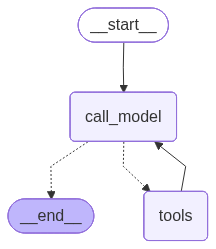

In [ ]:
graph

In [ ]:
# Run example
query = {"role": "user", "content": "What is ((((9+5)-56)*50)/2)"}
result = graph.invoke({"messages": [query]})

print("\nConversation:")
for m in result["messages"]:
    print(m)


Conversation:
content='What is ((((9+5)-56)*50)/2)' additional_kwargs={} response_metadata={} id='350f51d0-28a2-4ecc-8727-e83336a29609'
content='' additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"expression": "(((9+5)-56)*50)/2"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--6077a7b7-03ab-43da-b5fb-8270207feee0-0' tool_calls=[{'name': 'calculator', 'args': {'expression': '(((9+5)-56)*50)/2'}, 'id': '55f5c5ce-e153-45ef-8baa-1d8c46c2f624', 'type': 'tool_call'}] usage_metadata={'input_tokens': 52, 'output_tokens': 24, 'total_tokens': 112, 'input_token_details': {'cache_read': 0}}
content='-1050.0' name='calculator' id='87214f4d-cee2-48e6-9ade-8772b39332b8' tool_call_id='55f5c5ce-e153-45ef-8baa-1d8c46c2f624'
content='The result is -1050.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety

Planning

In [ ]:
# Set up the Language Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

# Define the State
# We need separate fields for each worker's results.
class PlannerState(TypedDict):
    task: str
    plan: list[str]
    graphql_results: str  # Results from the GraphQL researcher
    rest_results: str     # Results from the REST researcher
    final_output: str     # The final written summary

# Define the Tools and Workers

# Dummy tools for our researchers
def graphql_search_tool(query: str):
    """A dummy tool that returns fixed info about GraphQL."""
    print(f"GRAPHQL RESEARCHER: Searching for '{query}'")
    return "GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema."

def rest_search_tool(query: str):
    """A dummy tool that returns fixed info about REST."""
    print(f"REST RESEARCHER: Searching for '{query}'")
    return "REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid."

# Worker Nodes
def graphql_research_worker(state: PlannerState):
    """Worker node that researches GraphQL pros."""
    results = graphql_search_tool("pros of GraphQL")
    return {"graphql_results": results}

def rest_research_worker(state: PlannerState):
    """Worker node that researches REST cons."""
    results = rest_search_tool("cons of REST APIs")
    return {"rest_results": results}

def writer_worker(state: PlannerState):
    """
    Synthesizer node that waits for all research and writes the final output.
    This node acts as the "join" point.
    """
    print("WRITER: Synthesizing results")
    graphql_results = state['graphql_results']
    rest_results = state['rest_results']

    writing_prompt = f"""
    Write a short, balanced comparison post based on the following research.

    GraphQL Information:
    {graphql_results}

    REST API Information:
    {rest_results}
    """
    response = llm.invoke(writing_prompt)
    return {"final_output": response.content}

# Define the Planner
def planner(state: PlannerState):
    """Planner node that creates the initial plan."""
    print("PLANNER: Creating a plan for parallel execution")
    # For this example, the plan is hardcoded.
    # In a real app, an LLM would generate this based on the task.
    plan = [
        "Research GraphQL pros",
        "Research REST cons",
        "Write comparison post"
    ]
    return {"plan": plan}

# Build the Graph
workflow = StateGraph(PlannerState)

# Add the nodes
workflow.add_node("planner", planner)
workflow.add_node("graphql_researcher", graphql_research_worker)
workflow.add_node("rest_researcher", rest_research_worker)
workflow.add_node("writer", writer_worker)

# Set the entry point
workflow.set_entry_point("planner")

# Define the parallel edges
# After the planner, both research workers are called.
workflow.add_edge("planner", "graphql_researcher")
workflow.add_edge("planner", "rest_researcher")

# Define the join point
# The writer will only run after BOTH research workers are complete.
workflow.add_edge("graphql_researcher", "writer")
workflow.add_edge("rest_researcher", "writer")

# The graph ends after the writer is done
workflow.add_edge("writer", END)

# Compile the graph
graph = workflow.compile()

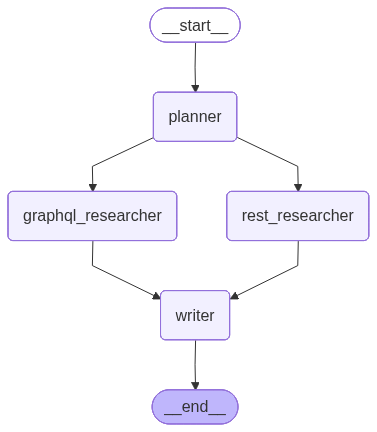

In [ ]:
graph

In [ ]:
# Run the Graph
user_task = "Write a short post comparing the pros of GraphQL with the cons of REST APIs and role of both in data aggregation ."
initial_state = {"task": user_task}

# Stream the events to see the execution flow
for event in graph.stream(initial_state):
    for key, value in event.items():
        print(f"Node '{key}' output:")
        print("---")
        print(value)
        print("\n" + "="*30 + "\n")

# Get the final output
final_state = graph.invoke(initial_state)
print("Final Comparison Post:")
print(final_state['final_output'])

PLANNER: Creating a plan for parallel execution
Node 'planner' output:
---
{'plan': ['Research GraphQL pros', 'Research REST cons', 'Write comparison post']}


GRAPHQL RESEARCHER: Searching for 'pros of GraphQL'
Node 'graphql_researcher' output:
---
{'graphql_results': 'GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema.'}


REST RESEARCHER: Searching for 'cons of REST APIs'
Node 'rest_researcher' output:
---
{'rest_results': 'REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid.'}


WRITER: Synthesizing results
Node 'writer' output:
---
{'final_output': '## GraphQL vs. REST APIs: A Quick Comparison\n\nWhen building APIs, developers often face the choice between GraphQL and REST APIs. Both approaches have their strengths and weaknesses, and the best choice depends on the specific needs of your project.\n\n**GraphQL shines in data efficiency and flexibilit